In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import cv2
import umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from mmdet.datasets import build_dataset, build_dataloader
from mmdet.apis import init_detector, inference_detector
from mmcv import Config

In [ ]:
# Specify the path to model config and checkpoint file
cfg = Config.fromfile("../configs/gwhd/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_3x_gwhd.py")
checkpoint_file = '../experiments/moby_swin_t_imnet_mask_rcnn_3x/latest.pth'

# build the model from a config file and a checkpoint file
model = init_detector(cfg, checkpoint_file)

In [ ]:
cfg.data.val.ann_file = "gwhd_2021/annotations/test.json"
cfg.data.val.img_prefix = "gwhd_2021/images"
dataset = build_dataset(cfg.data.val, dict(test_mode=True))

In [ ]:
from mmcv import ProgressBar

dataloader = build_dataloader(
                dataset, 
                16,
                cfg.data.workers_per_gpu,
                shuffle=False,
                dist=False)

results = []
prog_bar = ProgressBar(len(dataset))
for idx, batch in enumerate(dataloader):
    imgs = [item["filename"] for item in batch['img_metas'][0].data[0]]
    result = inference_detector(model, imgs)
    batch_size = len(result)
    results.extend(result)
    for _ in range(batch_size):
        prog_bar.update()

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.LongestMaxSize(1024,p=1),
    A.PadIfNeeded(min_height=1024,min_width=1024,p=1,border_mode=1,value=0),
    A.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),

],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels'],min_area=20))

In [4]:
def collate_fn(batch):
    """
    Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

    :param batch: an iterable of N sets from __getitem__()
    :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
    """

    images = list()
    targets=list()
    metadata = list()

    for i, t, m in batch:
        images.append(i)
        targets.append(t)
        metadata.append(m)
    images = torch.stack(images, dim=0)

    return images, targets, metadata

In [5]:
# implement dataset and dataloader
from datasets import WheatDataset

#dataset = datasets.CIFAR100('/home/ogidif/datasets', train=True, transform=transform, download=True)
csv_path = '/home/ogidif/datasets/gwhd_2021/competition_train.csv'
root_dir = '/home/ogidif/datasets/gwhd_2021/images'
dataset = WheatDataset(csv_path, root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, num_workers=2, pin_memory=True, 
                drop_last=False, collate_fn=collate_fn)

In [6]:
import sys
sys.path.append("/home/ogidif/models/Swin-Transformer")

from torchvision.models import resnet50
from pl_bolts.models.self_supervised import SwAV

from models.swin_transformer import SwinTransformer


def load_swav_encoder(pretrained_url):
    'from https://lightning-bolts.readthedocs.io/en/latest/self_supervised_models.html#imagenet-baseline-for-swav'
    weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
    swav = SwAV.load_from_checkpoint(weight_path, strict=False)
    encoder = swav.model

    # remove the projection head and prototypes (last two layers)
    encoder = torch.nn.Sequential(*list(encoder.children())[:-2])

    return encoder

def load_barlow_twins_encoder(pretrained_url):
    encoder = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

    official_pretrained_url = 'https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth'

    # remove fully connected layer
    encoder.fc = torch.nn.Identity() 
    return encoder

def load_moby_encoder(pretrained_url):
    '''
    from https://github.com/SwinTransformer/Transformer-SSL/blob/main/utils.py)
    '''
    encoder = SwinTransformer(img_size=224, patch_size=4, in_chans=3, num_classes=1000, embed_dim=96,
                        depths=[ 2, 2, 6, 2 ], num_heads=[ 3, 6, 12, 24 ], window_size=7, mlp_ratio=4., qkv_bias=True,
                        qk_scale=None, drop_rate=0., drop_path_rate=0.2, ape=False, patch_norm=True,
                        use_checkpoint=False)

    official_pretrained_url = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.3/moby_swin_t_300ep_pretrained.pth'
    
    # load pretrained checkpoint
    ckpt = load_pretrained_ckpt(pretrained_url or official_pretrained_url)
    
    state_dict = ckpt['model']
    model_dict = encoder.state_dict()

    # rename MoBY encoder
    state_dict = {k.replace('encoder.', ''): v for k, v in state_dict.items() if 'encoder.' in k}

    # copy head from encoder state_dict
    for k in model_dict.keys():
        if 'head' in k:
            state_dict[k] = model_dict[k]
    
    # load the state_dict
    missing_keys, unexpected_keys = encoder.load_state_dict(state_dict, strict=False)
    print(f'Missing keys: {missing_keys}\nUnexpected keys: {unexpected_keys}')

    # remove classification head
    encoder.head = torch.nn.Identity()

    return encoder

def load_mocov2_encoder(pretrained_url):
    '''
    from https://github.com/facebookresearch/moco/blob/master/main_lincls.py
    '''
    encoder = resnet50()
    official_pretrained_url = 'https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar'
    ckpt = load_pretrained_ckpt(pretrained_url or official_pretrained_url)
    state_dict = ckpt['state_dict']

    for k in list(state_dict.keys()):
        # retain only encoder_q up to before the embedding layer
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            # remove prefix
            state_dict[k[len("module.encoder_q."):]] = state_dict[k]
        
        # delete renamed or unused k
        del state_dict[k]
    
    msg = encoder.load_state_dict(state_dict, strict=False)
    print(f'Missing keys: {msg.missing_keys}\nUnexpected keys: {msg.unexpected_keys}')

    # remove last layer
    encoder.fc = torch.nn.Identity()

    return encoder

def load_sim_siam_encoder(pretrained_url):
    '''
    from https://github.com/facebookresearch/simsiam/blob/main/main_lincls.py
    '''
    encoder = resnet50()
    official_pretrained_url = 'https://dl.fbaipublicfiles.com/simsiam/models/100ep-256bs/pretrain/checkpoint_0099.pth.tar'
    ckpt = load_pretrained_ckpt(pretrained_url or official_pretrained_url)
    state_dict = ckpt['state_dict']

    for k in list(state_dict.keys()):
        # retain only encoder up to before the embedding layer
        if k.startswith('module.encoder') and not k.startswith('module.encoder.fc'):
            # remove prefix
            state_dict[k[len("module.encoder."):]] = state_dict[k]
        
        # delete renamed or unused k
        del state_dict[k]
    
    msg = encoder.load_state_dict(state_dict, strict=False)
    print(f'Missing keys: {msg.missing_keys}\nUnexpected keys: {msg.unexpected_keys}')

    return encoder

def load_pretrained_ckpt(pretrained_url):
    if pretrained_url.startswith('http'):
        checkpoint = torch.hub.load_state_dict_from_url(pretrained_url, 
                            map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.hub.load_state_dict_from_url(pretrained_url,
                        map_location='cpu')
    return checkpoint

def get_encoder(name, pretrained=False, pretrained_url=None):
    assert name in ['resnet', 'swin', 'moby', 'moco_v2', 'swav', 'sim_siam', 'barlow_twins']
    if name == 'resnet':
        # load ResNet model
        encoder = resnet50(pretrained=pretrained)

        if pretrained and pretrained_url:
            ckpt = load_pretrained_ckpt(pretrained_url)
            encoder.load_state_dict(ckpt['model'], strict=False)

        # remove last layer
        encoder.fc = torch.nn.Identity()
    elif name == 'swin':
        encoder = SwinTransformer(img_size=1024, patch_size=4, in_chans=3, num_classes=1000, embed_dim=96,
                        depths=[ 2, 2, 6, 2 ], num_heads=[ 3, 6, 12, 24 ], window_size=7, mlp_ratio=4., qkv_bias=True,
                        qk_scale=None, drop_rate=0., drop_path_rate=0.2, ape=False, patch_norm=True,
                        use_checkpoint=False)

        # load pretrained checkpoint
        if pretrained and pretrained_url:
            ckpt = load_pretrained_ckpt(pretrained_url)    
            msg = encoder.load_state_dict(ckpt['model'], strict=False)
            print(f'Missing keys: {msg.missing_keys}\nUnexpected keys: {msg.unexpected_keys}')
        
        # remove the last layer
        encoder.head = torch.nn.Identity()
    elif name == 'moby':
        encoder = load_moby_encoder(pretrained_url)
    elif name =='moco_v2':
        encoder = load_mocov2_encoder(pretrained_url)
    elif name == 'swav':
        encoder = load_swav_encoder(pretrained_url)
    elif name == 'sim_siam':
        encoder = load_sim_siam_encoder(pretrained_url)
    else:
        encoder = load_barlow_twins_encoder(pretrained_url)
    return encoder

In [7]:
# swin transformer (tiny) pretrained on ImageNet
#pretrained_url = 'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth'
pretrained_url = None

encoder = get_encoder(name='swav', pretrained=True, pretrained_url=pretrained_url)

# freeze the encoder
for param in encoder.parameters():
    param.requires_grad = False

encoder.cuda();

Downloading: "https://github.com/facebookresearch/barlowtwins/archive/main.zip" to /home/ogidif/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /home/ogidif/.cache/torch/hub/checkpoints/resnet50.pth
100%|██████████| 90.0M/90.0M [00:15<00:00, 6.16MB/s]


In [8]:
representations = []

for batch in dataloader:
    rep = encoder(batch[0].cuda())
    representations.extend(rep.detach().cpu().numpy())
representations = np.squeeze(representations)
print(representations.shape)

/home/ogidif/miniconda3/envs/viz/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(3657, 2048)


In [9]:
# helper function to process image - flatten
'''data = []
for img, target in dataloader:
    shape = torch.Tensor(list(img.shape[1:]))
    vec_size = int(torch.prod(shape).item())
    data.append(img.view(vec_size).numpy())
data = np.array(data)'''

'data = []\nfor img, target in dataloader:\n    shape = torch.Tensor(list(img.shape[1:]))\n    vec_size = int(torch.prod(shape).item())\n    data.append(img.view(vec_size).numpy())\ndata = np.array(data)'

In [10]:
# apply umap
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42)
reducer.fit(representations)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.5, n_neighbors=50,
     random_state=42)

In [11]:
# plot
embedding = reducer.embedding_
embedding.shape

(3657, 2)

In [12]:
# global seaborn plots setting
sns.set(style='white', context='notebook', rc={'figure.figsize':(20, 15)})

In [13]:
print(len(dataset.image_list))

3657


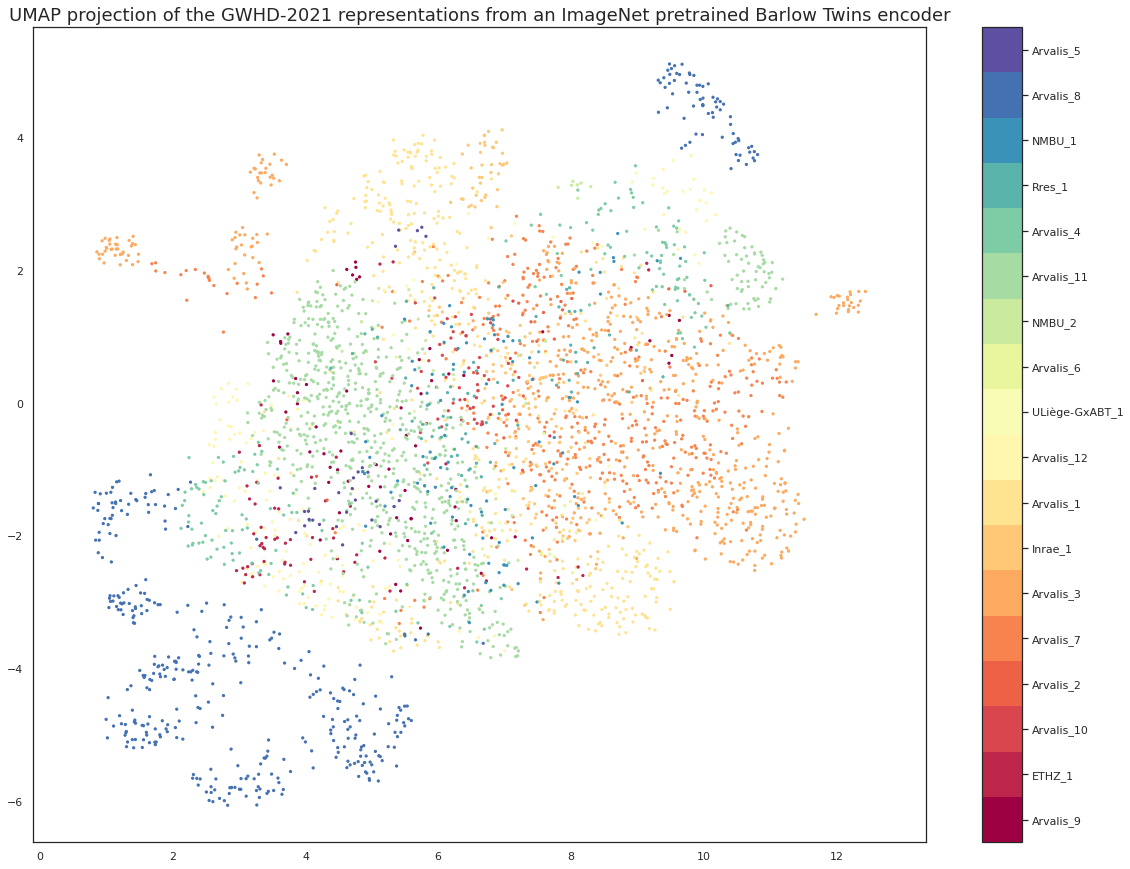

In [14]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=dataset.domain_cat, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(boundaries=np.arange(19)-0.5)
cbar.set_ticks(np.arange(18))
cbar.set_ticklabels(list(set(dataset.domain_str)))
plt.title('UMAP projection of the GWHD-2021 representations from an ImageNet pretrained SWaV encoder', fontsize=18);
plt.savefig('plots/gwhd_2021_ssl_imagenet_swav_umap_nn50_md05.png')